# Forecasting with an LSTM

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

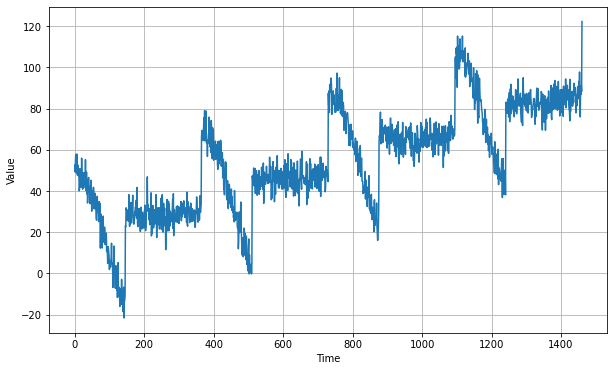

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,   # you can use RNN with LSTM cell but it will be slow
                    batch_input_shape=[1, None, 1]),             # this is optized with Nvidia library
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 8s 240ms/step - loss: 90.9191 - mae: 91.419190.3619 - mae: 90.
Epoch 2/100
33/33 [==============================] - 1s 38ms/step - loss: 83.4068 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 1s 37ms/step - loss: 75.0500 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 1s 36ms/step - loss: 65.6706 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 1s 36ms/step - loss: 55.1746 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 1s 37ms/step - loss: 43.4886 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 1s 36ms/step - loss: 30.5977 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 1s 37ms/step - loss: 17.0357 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 1s 37ms/step - loss: 9.9728 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 1s 38ms/step - loss: 10.0635 - mae: 10.5524
Epoch 11/10

33/33 [==============================] - 1s 31ms/step - loss: 18.8948 - mae: 18.9399
Epoch 86/100
33/33 [==============================] - 1s 36ms/step - loss: 19.5401 - mae: 19.6195: 1s - loss: 22.1675 -
Epoch 87/100
33/33 [==============================] - 1s 32ms/step - loss: 29.3786 - mae: 30.9667
Epoch 88/100
33/33 [==============================] - 1s 30ms/step - loss: 24.7874 - mae: 25.8407
Epoch 89/100
33/33 [==============================] - 1s 35ms/step - loss: 27.6462 - mae: 27.6091
Epoch 90/100
33/33 [==============================] - 1s 31ms/step - loss: 34.9819 - mae: 34.8824
Epoch 91/100
33/33 [==============================] - 1s 29ms/step - loss: 26.0090 - mae: 26.8708
Epoch 92/100
33/33 [==============================] - 1s 34ms/step - loss: 44.7303 - mae: 45.9150
Epoch 93/100
33/33 [==============================] - 2s 52ms/step - loss: 43.9079 - mae: 43.4456
Epoch 94/100
33/33 [==============================] - 2s 46ms/step - loss: 37.9999 - mae: 37.6035
Epoch 95/10

(1e-08, 0.0001, 0.0, 30.0)

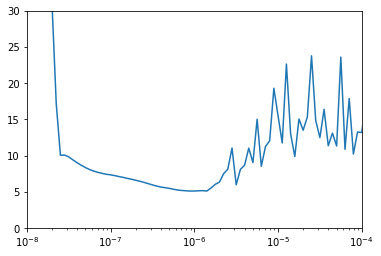

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 8s 232ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
33/33 [==============================] - 1s 38ms/step - loss: 17.3352 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 44ms/step - loss: 12.6847 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 2s 46ms/step - loss: 11.3142 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 2s 56ms/step - loss: 8.2134 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 2s 50ms/step - loss: 7.8129 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 44ms/step - loss: 6.0659 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [=============================

33/33 [==============================] - 1s 42ms/step - loss: 4.7853 - mae: 5.3581 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/500
33/33 [==============================] - 1s 41ms/step - loss: 4.7783 - mae: 5.3520 - val_loss: 7.7333 - val_mae: 8.2205
Epoch 64/500
33/33 [==============================] - 1s 42ms/step - loss: 4.7755 - mae: 5.3498 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/500
33/33 [==============================] - 1s 41ms/step - loss: 4.7742 - mae: 5.3490 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/500
33/33 [==============================] - 1s 42ms/step - loss: 4.7728 - mae: 5.3477 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/500
33/33 [==============================] - 1s 42ms/step - loss: 4.7699 - mae: 5.3447 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/500
33/33 [==============================] - 1s 42ms/step - loss: 4.7644 - mae: 5.3386 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/500
33/33 [==============================] - 1s 41ms/step - loss: 4.7554 

33/33 [==============================] - 1s 44ms/step - loss: 4.4862 - mae: 5.0497 - val_loss: 6.3984 - val_mae: 6.8797
Epoch 124/500
33/33 [==============================] - 2s 46ms/step - loss: 4.4932 - mae: 5.0579 - val_loss: 6.3481 - val_mae: 6.8289
Epoch 125/500
33/33 [==============================] - 2s 51ms/step - loss: 4.5025 - mae: 5.0683 - val_loss: 6.2882 - val_mae: 6.7687
Epoch 126/500
33/33 [==============================] - 2s 46ms/step - loss: 4.5102 - mae: 5.0763 - val_loss: 6.2286 - val_mae: 6.7081
Epoch 127/500
33/33 [==============================] - 2s 48ms/step - loss: 4.5146 - mae: 5.0805 - val_loss: 6.1631 - val_mae: 6.6415
Epoch 128/500
33/33 [==============================] - 2s 46ms/step - loss: 4.5159 - mae: 5.0804 - val_loss: 6.1097 - val_mae: 6.5878
Epoch 129/500
33/33 [==============================] - 2s 46ms/step - loss: 4.5135 - mae: 5.0763 - val_loss: 6.0685 - val_mae: 6.5467
Epoch 130/500
33/33 [==============================] - 2s 46ms/step - loss: 

33/33 [==============================] - 1s 42ms/step - loss: 4.3922 - mae: 4.9561 - val_loss: 5.8717 - val_mae: 6.3485
Epoch 185/500
33/33 [==============================] - 1s 41ms/step - loss: 4.3875 - mae: 4.9501 - val_loss: 5.8624 - val_mae: 6.3390
Epoch 186/500
33/33 [==============================] - 1s 42ms/step - loss: 4.3833 - mae: 4.9448 - val_loss: 5.8582 - val_mae: 6.3346
Epoch 187/500
33/33 [==============================] - 1s 44ms/step - loss: 4.3797 - mae: 4.9402 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 188/500
33/33 [==============================] - 2s 54ms/step - loss: 4.3768 - mae: 4.9368 - val_loss: 5.8563 - val_mae: 6.3326
Epoch 189/500
33/33 [==============================] - 2s 49ms/step - loss: 4.3747 - mae: 4.9344 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 190/500
33/33 [==============================] - 2s 47ms/step - loss: 4.3733 - mae: 4.9328 - val_loss: 5.8560 - val_mae: 6.3323
Epoch 191/500
33/33 [==============================] - 2s 46ms/step - loss: 

33/33 [==============================] - 1s 45ms/step - loss: 4.3233 - mae: 4.8811 - val_loss: 5.6969 - val_mae: 6.1752
Epoch 246/500
33/33 [==============================] - 1s 44ms/step - loss: 4.3221 - mae: 4.8782 - val_loss: 5.8805 - val_mae: 6.3587
Epoch 247/500
33/33 [==============================] - 1s 43ms/step - loss: 4.3173 - mae: 4.8718 - val_loss: 5.5998 - val_mae: 6.0781
Epoch 248/500
33/33 [==============================] - 1s 45ms/step - loss: 4.3292 - mae: 4.8880 - val_loss: 5.9419 - val_mae: 6.4210
Epoch 249/500
33/33 [==============================] - 1s 44ms/step - loss: 4.3178 - mae: 4.8721 - val_loss: 5.5768 - val_mae: 6.0553
Epoch 250/500
33/33 [==============================] - 1s 44ms/step - loss: 4.3351 - mae: 4.8947 - val_loss: 5.8366 - val_mae: 6.3139
Epoch 251/500
33/33 [==============================] - 1s 44ms/step - loss: 4.3206 - mae: 4.8780 - val_loss: 5.5932 - val_mae: 6.0717
Epoch 252/500
33/33 [==============================] - 1s 43ms/step - loss: 

33/33 [==============================] - 1s 43ms/step - loss: 4.2850 - mae: 4.8481 - val_loss: 5.7804 - val_mae: 6.2604
Epoch 307/500
33/33 [==============================] - 1s 43ms/step - loss: 4.2861 - mae: 4.8357 - val_loss: 5.4070 - val_mae: 5.8882
Epoch 308/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2965 - mae: 4.8600 - val_loss: 5.5796 - val_mae: 6.0588
Epoch 309/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2839 - mae: 4.8473 - val_loss: 5.8005 - val_mae: 6.2803
Epoch 310/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2837 - mae: 4.8337 - val_loss: 5.4058 - val_mae: 5.8870
Epoch 311/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2949 - mae: 4.8587 - val_loss: 5.5800 - val_mae: 6.0592
Epoch 312/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2825 - mae: 4.8461 - val_loss: 5.8259 - val_mae: 6.3052
Epoch 313/500
33/33 [==============================] - 1s 41ms/step - loss: 

33/33 [==============================] - 1s 43ms/step - loss: 4.2528 - mae: 4.8126 - val_loss: 5.4177 - val_mae: 5.8990
Epoch 368/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2665 - mae: 4.8355 - val_loss: 5.5700 - val_mae: 6.0499
Epoch 369/500
33/33 [==============================] - 1s 40ms/step - loss: 4.2557 - mae: 4.8262 - val_loss: 5.9715 - val_mae: 6.4525
Epoch 370/500
33/33 [==============================] - 2s 52ms/step - loss: 4.2571 - mae: 4.8140 - val_loss: 5.3823 - val_mae: 5.8632
Epoch 371/500
33/33 [==============================] - 2s 53ms/step - loss: 4.2676 - mae: 4.8371 - val_loss: 5.5706 - val_mae: 6.0503
Epoch 372/500
33/33 [==============================] - 2s 50ms/step - loss: 4.2559 - mae: 4.8260 - val_loss: 6.0416 - val_mae: 6.5240
Epoch 373/500
33/33 [==============================] - 2s 53ms/step - loss: 4.2502 - mae: 4.8106 - val_loss: 5.4159 - val_mae: 5.8972
Epoch 374/500
33/33 [==============================] - 2s 57ms/step - loss: 

33/33 [==============================] - 2s 47ms/step - loss: 4.2455 - mae: 4.8200 - val_loss: 5.6689 - val_mae: 6.1502
Epoch 429/500
33/33 [==============================] - 2s 47ms/step - loss: 4.2325 - mae: 4.8079 - val_loss: 6.0609 - val_mae: 6.5440
Epoch 430/500
33/33 [==============================] - 2s 48ms/step - loss: 4.2352 - mae: 4.8036 - val_loss: 5.4265 - val_mae: 5.9075
Epoch 431/500
33/33 [==============================] - 1s 41ms/step - loss: 4.2408 - mae: 4.8143 - val_loss: 5.9258 - val_mae: 6.4078
Epoch 432/500
33/33 [==============================] - 1s 42ms/step - loss: 4.2269 - mae: 4.7979 - val_loss: 5.4848 - val_mae: 5.9663


In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

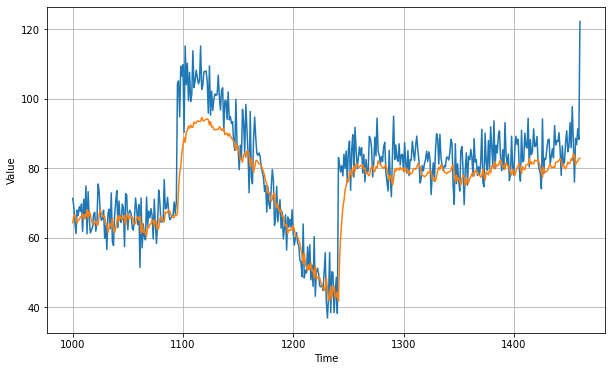

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.977645